In [1]:
%run ../ipynb_util_tars.py

In [2]:
%run ../ipynb_load_data_natural.py

{'SDG': Value(dtype='int64', id=None), 'ABSTRACT': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'sdg_desc_short': Value(dtype='string', id=None), 'sdg_desc_long': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}
Example instance:	 {'SDG': 8, 'ABSTRACT': 'The scheme gives enterprises with business activity in Norway a tax credit on their R&D projects. The R&D content must be approved by the Research Council of Norway ex ante. In 2009, the cap on expenses per enterprise for intramural R&D projects increased to NOK 5.5 million (previously it was N0K 4 million), and NOK11 million (previously it was NOK 8 million) for projects conducted at an R&D institution.', 'id': None, 'sdg_desc_short': None, 'sdg_desc_long': None, '__index_level_0__': 492}
id2label: {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16', 16: '17'}
label2id: {'1': 0, '2': 1, '

In [3]:
torch.set_printoptions(precision=6, sci_mode=False)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

def improved_colored_text_plot(tokens, values, model_name):
    # Normalize values to range [-1, 1]
    max_abs_value = max(abs(min(values)), abs(max(values)))
    normalized_values = [v / max_abs_value for v in values]

    # Create a custom colormap (blue for negative, white for neutral, red for positive)
    colors = ['blue', 'white', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_xlim(0, len(tokens))
    ax.set_ylim(-0.5, 0.5)
    ax.axis('off')

    # Plot colored rectangles and text for each token
    for i, (token, value) in enumerate(zip(tokens, normalized_values)):
        color = cmap((value + 1) / 2)
        rect = Rectangle((i, -0.2), 0.9, 0.4, facecolor=color, edgecolor='none')
        ax.add_patch(rect)
        ax.text(i + 0.45, 0, token, ha='center', va='center', fontsize=8, rotation=90)

    if model_name is not None:
        plt.title("Relevancy scores for model: " + model_name)
    else:
        plt.title('Token Relevancy Visualization')
    plt.tight_layout()
    plt.show()

In [5]:
"""load pretrained llama"""
import torch
from transformers import AutoTokenizer
from transformers.models.llama.modeling_llama import LlamaForSequenceClassification
from lxt.models.llama import (
    # LlamaForSequenceClassification,
    attnlrp
)

model_name = f"{CHECKPOINT_PATH}/final/meta-llama/Llama-2-7b-hf-noq/checkpoint-632"
model_name = f"{CHECKPOINT_PATH}/final/meta-llama/Meta-Llama-3-8B-ft-zo_up/checkpoint-2212/"
#model_name = f"{CHECKPOINT_PATH}/TinyLlama/TinyLlama_v1.1/checkpoint-100/"
#model_name = f"{CHECKPOINT_PATH}/TinyLlama/TinyLlama_v1.1/checkpoint-80"
#model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# model = LlamaForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=17,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     token=HF_TOKEN
# )
# model.config.pad_token_id = tokenizer.pad_token_id

# print("Model before AttnLRP rules:", model)

# # apply AttnLRP rules
# print("=" * 40, "\n")
# print("Model after AttnLRP rules:", attnlrp.register(model))


# Use AttnLRP LlamaForSequenceClassification model for comparison
from lxt.models.llama import LlamaForSequenceClassification as LlamaForSequenceClassificationAttnLRP

model_attnlrp = LlamaForSequenceClassificationAttnLRP.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    token=HF_TOKEN
)
model_attnlrp.eval()
print("=" * 40, "\n")
print("AttnLRP llama rules:", model_attnlrp)

from peft import PeftModel

peft_model = PeftModel.from_pretrained(model_attnlrp, model_id=model_name)
model_attnlrp = peft_model.merge_and_unload()

print("=" * 40, "\n")
print("Model after AttnLRP rules:", attnlrp.register(model_attnlrp, verbose=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



AttnLRP llama rules: LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): LinearEpsilon(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): LinearEpsilon(in_features=4096, out_features=1024, bias=False)
          (v_proj): lora.Linear(
            (base_layer): LinearEpsilon(in_features=4096, out_feature

In [6]:
#sample_sentence = "This is about clean energy, and also affordable energy."
#sample_sentence = "Is this about clean energy?"
sample_sentence = "In terms of regional shares in the OECD area, OECD Europe’s share of consumption is slightly higher than the region’s share of extraction, while the inverse if tme for the OECD America region. The OECD Asia-Oceania region’s share of consumption is the same as its share of extraction. Average income plays a particularly important role. Most of these countries experienced a strong upswing in material extraction starting the early 2000s, although China’s surge began much earlier. By the early 1990s China had overtaken the United States as the world’s largest extractor of material resources."
#sample_sentence = "Ensure access to affordable, reliable, sustainable and modern energy for all"
#sample_sentence = "Tackling supply deficits within individual catchments will be a high cost approach, increasing the requirement for new infrastructure, and requiring more constraint on water use. However, water is heavy and pumping - and carbon - costs are high, so large scale, long distance transfers are expensive, relative to the water’s value. But there is scope for greater interconnection within and between water companies."


idx = 2
sample_sentence = dataset["train"][idx]["ABSTRACT"]
print(dataset["train"][idx]["SDG"] + 1)


In [7]:
# Tokenize the sentence
tokenized_output = tokenizer(sample_sentence, return_tensors="pt", add_special_tokens=True)

# Extract token IDs
token_ids = tokenized_output['input_ids'][0].tolist()

# Decode token IDs to readable string
decoded_sentence = tokenizer.decode(token_ids, skip_special_tokens=True)

print("Token IDs:", token_ids)
print("Decoded sentence:", decoded_sentence)

Token IDs: [128000, 644, 3878, 315, 15481, 13551, 304, 279, 79517, 3158, 11, 79517, 4606, 753, 4430, 315, 15652, 374, 10284, 5190, 1109, 279, 5654, 753, 4430, 315, 33289, 11, 1418, 279, 29049, 422, 259, 2727, 369, 279, 79517, 5270, 5654, 13, 578, 79517, 13936, 24540, 346, 9345, 5654, 753, 4430, 315, 15652, 374, 279, 1890, 439, 1202, 4430, 315, 33289, 13, 24478, 8070, 11335, 264, 8104, 3062, 3560, 13, 7648, 315, 1521, 5961, 10534, 264, 3831, 709, 86384, 304, 3769, 33289, 6041, 279, 4216, 220, 1049, 15, 82, 11, 8051, 5734, 753, 22531, 6137, 1790, 6931, 13, 3296, 279, 4216, 220, 2550, 15, 82, 5734, 1047, 43661, 3448, 279, 3723, 4273, 439, 279, 1917, 753, 7928, 68572, 315, 3769, 5070, 13]
Decoded sentence: In terms of regional shares in the OECD area, OECD Europe’s share of consumption is slightly higher than the region’s share of extraction, while the inverse if tme for the OECD America region. The OECD Asia-Oceania region’s share of consumption is the same as its share of extraction. Ave

output shape torch.Size([1, 17])
torch.Size([1, 120, 4096])
torch.Size([1, 120, 4096])
tensor(11, device='cuda:0')
The label of the sequence is:  12
['<|begin\\_of\\_text|>', 'In', 'Ġterms', 'Ġof', 'Ġregional', 'Ġshares', 'Ġin', 'Ġthe', 'ĠOECD', 'Ġarea', ',', 'ĠOECD', 'ĠEurope', 'âĢĻs', 'Ġshare', 'Ġof', 'Ġconsumption', 'Ġis', 'Ġslightly', 'Ġhigher', 'Ġthan', 'Ġthe', 'Ġregion', 'âĢĻs', 'Ġshare', 'Ġof', 'Ġextraction', ',', 'Ġwhile', 'Ġthe', 'Ġinverse', 'Ġif', 'Ġt', 'me', 'Ġfor', 'Ġthe', 'ĠOECD', 'ĠAmerica', 'Ġregion', '.', 'ĠThe', 'ĠOECD', 'ĠAsia', '-O', 'ce', 'ania', 'Ġregion', 'âĢĻs', 'Ġshare', 'Ġof', 'Ġconsumption', 'Ġis', 'Ġthe', 'Ġsame', 'Ġas', 'Ġits', 'Ġshare', 'Ġof', 'Ġextraction', '.', 'ĠAverage', 'Ġincome', 'Ġplays', 'Ġa', 'Ġparticularly', 'Ġimportant', 'Ġrole', '.', 'ĠMost', 'Ġof', 'Ġthese', 'Ġcountries', 'Ġexperienced', 'Ġa', 'Ġstrong', 'Ġup', 'swing', 'Ġin', 'Ġmaterial', 'Ġextraction', 'Ġstarting', 'Ġthe', 'Ġearly', 'Ġ', '200', '0', 's', ',', 'Ġalthough', 'ĠChina', 'âĢĻs', 'Ġ

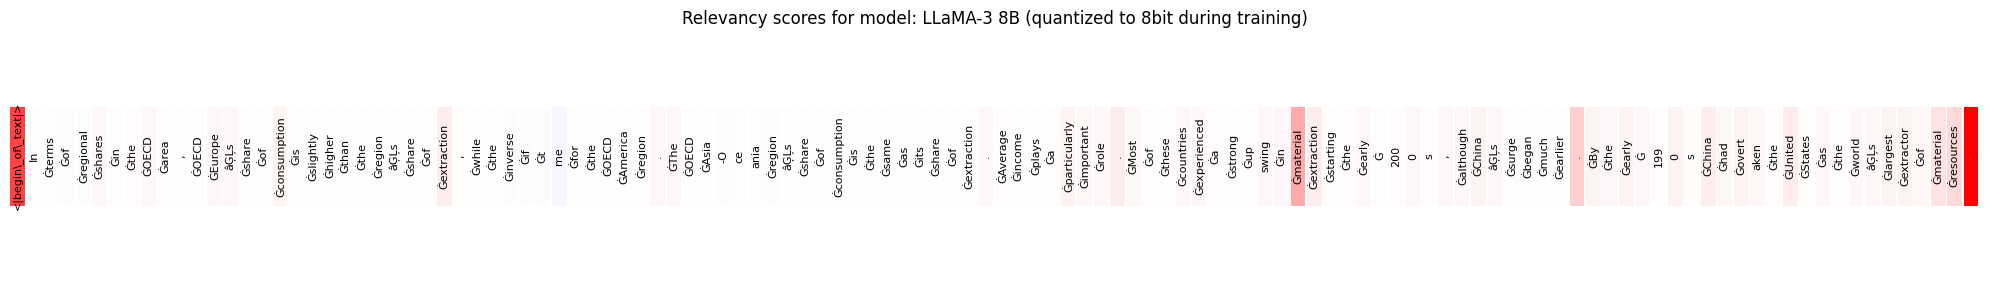

In [8]:
from lxt.utils import clean_tokens
import lxt.functional as lf

model = model_attnlrp

input_ids = tokenizer(
    sample_sentence,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(model.device)
input_embeds = model.get_input_embeddings()(input_ids)

output_logits = model(inputs_embeds=input_embeds.requires_grad_(), use_cache=False).logits
print("output shape", output_logits.shape)

max_logits, max_indices = torch.max(output_logits[0, :], dim=-1)

print(input_embeds.shape)
max_logits.backward(max_logits)
print(input_embeds.grad.shape)
relevance = input_embeds.grad.float().sum(-1).cpu()[0]

# normalize relevance between [-1, 1] for plotting
relevance = relevance / relevance.abs().max()

# remove '_' characters from token strings
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(tokens)

out = model.config.id2label[max_indices.item()]
print(max_indices)
print("The label of the sequence is: ", out)

print(tokens)
print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
print(relevance)
improved_colored_text_plot(tokens, relevance, "LLaMA-3 8B (quantized to 8bit during training)")

{'do_lower_case': False, 'unk_token': AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'sep_token': AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'pad_token': AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'cls_token': AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'tokenize_chinese_chars': True, 'strip_accents': None, 'clean_up_tokenization_spaces': True, 'do_basic_tokenize': True, 'model_max_length': 1000000000000000019884624838656, 'never_split': None, 'name_or_path': '/srv/scratch2/dbielik/.cache/huggingface/checkpoints/final/allenai/scibert_scivocab_cased-zo_up/checkpoint-432/', 'max_length': 512, 'truncation_side': 'right', 'stride': 0, 'truncation_strategy': 

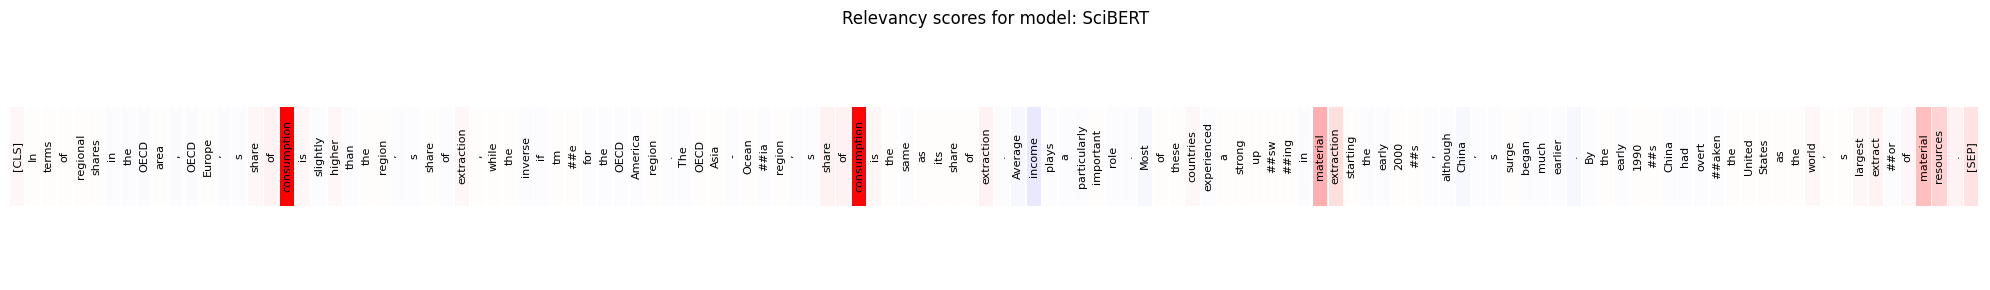

In [9]:
"""Requires `pip install -e ./lxt`"""
import torch
from transformers import AutoTokenizer
from lxt.models.bert import attnlrp, BertForSequenceClassification
from lxt.utils import pdf_heatmap, clean_tokens

def clean_wordpiece_split(tokens):
        """ BERT-specific cleaning. Workaround not working perfect yet."""
        return [word.replace("##", "") for word in tokens]

def seq_cls():
    """AttnLRP for BERT sequence classification task."""
    SCIBERT_MODEL = CHECKPOINT_PATH + "/final/allenai/scibert_scivocab_cased-zo_up/checkpoint-432/"
    #SCIBERT_MODEL = CHECKPOINT_PATH + "/final-nolowercase/allenai/scibert_scivocab_cased-zo_up/checkpoint-640/"
    tokenizer = AutoTokenizer.from_pretrained(
        SCIBERT_MODEL,
        do_lower_case=False
    )
    print(tokenizer.init_kwargs)
    model = BertForSequenceClassification.from_pretrained(
        SCIBERT_MODEL,
        id2label=id2label,
        label2id=label2id
    ).to(torch.device("cuda"))
    model.eval()

    # apply AttnLRP rules
    attnlrp.register(model)
    tokens = tokenizer(sample_sentence, padding=True, truncation=True, max_length=512, return_tensors="pt")
    print(tokenizer.convert_ids_to_tokens(tokens.input_ids[0]))
    input_ids = tokenizer(sample_sentence, return_tensors="pt").input_ids.to(torch.device("cuda"))
    inputs_embeds = model.bert.get_input_embeddings()(input_ids)

    logits = model(inputs_embeds=inputs_embeds.requires_grad_()).logits
    print(logits.shape)

    # We explain the sequence label: acceptable or unacceptable
    max_logits, max_indices = torch.max(logits, dim=-1)

    out = model.config.id2label[max_indices.item()]
    print(max_indices)
    print("The label of the sequence is: ", out)

    max_logits.backward(max_logits)

    relevance = inputs_embeds.grad.float().sum(-1).cpu()[0]
    # normalize relevance between [-1, 1] for plotting
    relevance = relevance / relevance.abs().max()

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens = tokens

    #pdf_heatmap(tokens, relevance, path="./heatmap_seq_cls.pdf", backend="xelatex")
    print(tokens)
    print(relevance)

    improved_colored_text_plot(tokens, relevance, "SciBERT")

seq_cls()

## FinBERT attnlrp on Sentiment classification

In [10]:
finbert = BertForSequenceClassification.from_pretrained(
    "nickmuchi/finbert-tone-finetuned-fintwitter-classification",
    num_labels=3,
).to("cuda")
finbert.eval()
tokenizer = AutoTokenizer.from_pretrained(
    "nickmuchi/finbert-tone-finetuned-fintwitter-classification"
)

sentence = "Citi gives big boost to Deere PT"
print(finbert(input_ids=tokenizer(sentence, return_tensors="pt").input_ids.to("cuda")))
attnlrp.register(finbert)

input_ids = tokenizer(sentence, return_tensors="pt").input_ids.to(torch.device("cuda"))
inputs_embeds = finbert.bert.get_input_embeddings()(input_ids)

logits = finbert(inputs_embeds=inputs_embeds.requires_grad_()).logits
print(logits.shape)

# We explain the sequence label: acceptable or unacceptable
max_logits, max_indices = torch.max(logits, dim=-1)

out = finbert.config.id2label[max_indices.item()]
print("The label of the sequence is: ", out)

max_logits.backward(max_logits)

relevance = inputs_embeds.grad.float().sum(-1).cpu()[0]
# normalize relevance between [-1, 1] for plotting
relevance = relevance / relevance.abs().max()

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(clean_wordpiece_split(tokens))

#pdf_heatmap(tokens, relevance, path="./heatmap_seq_cls.pdf", backend="xelatex")
print(tokens)
print(relevance)


SequenceClassifierOutput(loss=None, logits=tensor([[-4.712738,  2.973304, -2.078524]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
torch.Size([1, 3])
The label of the sequence is:  Bullish
['[CLS]', 'citi', 'gives', 'big', 'boost', 'to', 'deere', 'pt', '[SEP]']
tensor([-0.044548, -0.045781,  0.033255,  0.185055,  1.000000,  0.007080,
        -0.002039,  0.330254, -0.556027])
